# 课时92 语义分割网络模型

In [144]:
import pandas as pd
import numpy as np
import seaborn as sb
sb.set_style('darkgrid')
# pathlib相比os.path更好用
import pathlib
import random
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import glob
import os
# 导入下面的包用于绘制矩形框
from matplotlib.patches import Rectangle
from lxml import etree
print('Tensorflow Version:', tf.__version__)

Tensorflow Version: 2.0.0


# 1. 获取语义分割标注数据

In [145]:
semantic_segmentation_labels_path = 'D:/BaiduNetdiskDownload/日月光华-tensorflow资料/数据集/图片定位与分割数据集/annotations/trimaps'
len(os.listdir(semantic_segmentation_labels_path))

14780

array([1, 2, 3], dtype=uint8)

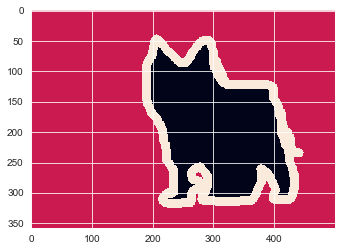

In [146]:
segmentation_img = tf.io.read_file(semantic_segmentation_labels_path + '/yorkshire_terrier_99.png')
segmentation_img = tf.image.decode_png(segmentation_img)
# 由于分割标签的channel为1，因此将这个1给去掉方便绘图
# 使用tf.squeeze()压缩图片的维度,它会自动把维度为1的给压缩掉，例如array([[1,2,3]]) --> array([1,2,3])
segmentation_img = tf.squeeze(segmentation_img)
plt.imshow(segmentation_img)
np.unique(segmentation_img.numpy())

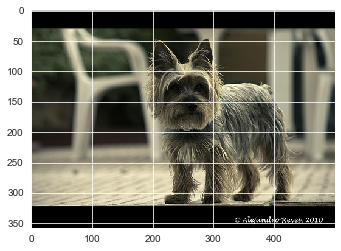

In [147]:
original_img = tf.io.read_file('D:/BaiduNetdiskDownload/日月光华-tensorflow资料/数据集/图片定位与分割数据集/images' + '/yorkshire_terrier_99.jpg')
original_img = tf.image.decode_jpeg(original_img)
plt.imshow(original_img)

In [163]:
# 开始读取所有图片的路径
original_images_path = 'D:/BaiduNetdiskDownload/日月光华-tensorflow资料/数据集/图片定位与分割数据集/images'
original_images = glob.glob(original_images_path + '/*.jpg')
semantic_segmentation_labels = glob.glob(semantic_segmentation_labels_path + '/*.png')
np.random.seed(2019)
index = np.random.permutation(len(original_images))
original_images = np.array(original_images)[index]
semantic_segmentation_labels = np.array(semantic_segmentation_labels)[index]

# 开始读取所有图片的路径
original_images_path = 'D:/BaiduNetdiskDownload/日月光华-tensorflow资料/数据集/图片定位与分割数据集/images'
original_images = glob.glob(original_images_path + '/*.jpg')
semantic_segmentation_labels = glob.glob(semantic_segmentation_labels_path + '/*.png')
# 对获取到的图片数据和分割标签进行排序，避免两个数据集之间的数据不是一一对应的
semantic_segmentation_labels.sort(key=lambda x: x.split('/')[-1].split('.')[0])
original_images.sort(key=lambda x: x.split('/')[-1].split('.')[0])
# 按照文件名排序完毕之后设定随机种子，对两个数据集进行乱序
np.random.seed(2019)
index = np.random.permutation(len(original_images))
original_images = np.array(original_images)[index]
semantic_segmentation_labels = np.array(semantic_segmentation_labels)[index]

In [167]:
len(original_images)

7390

In [149]:
# 将图片路径转换为Dataset数据集
dataset = tf.data.Dataset.from_tensor_slices((original_images, semantic_segmentation_labels))
# 划分数据集为训练集与测试集
test_count = int(len(original_images)*0.2)
train_count = len(original_images) - test_count
train_dataset = dataset.skip(test_count)
test_dataset = dataset.take(test_count)

In [150]:
# 定义对图像进行读取和预处理的操作
# 读取和解码jpg图片
def decode_jpg_images(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img
# 读取和解码png图片
def decode_png_images(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=1)
    return img
# 对图片进行归一化
def normal_images(input_images, input_masks):
    input_images = tf.cast(input_images, tf.float32)
    input_images = input_images/127.5 - 1
    # 将分割标签图像中的类别[1,2,3]转换为[0,1,2]
    input_masks -= 1
    return input_images, input_masks
# 加载图片
def load_images(input_images_path, input_masks_path):
    input_images = decode_jpg_images(input_images_path)
    input_masks = decode_png_images(input_masks_path)
    input_images = tf.image.resize(input_images, (224, 224))
    input_masks = tf.image.resize(input_masks, (224, 224))
    return normal_images(input_images, input_masks)

In [152]:
# 对数据进行map并进行shuffle和batch划分
BATCH_SIZE = 32
train_dataset = train_dataset.map(load_images, 
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.map(load_images,
                                num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=100).repeat().batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
train_dataset

<BatchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 1)), types: (tf.float32, tf.float32)>

In [153]:
train_dataset

<BatchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 1)), types: (tf.float32, tf.float32)>

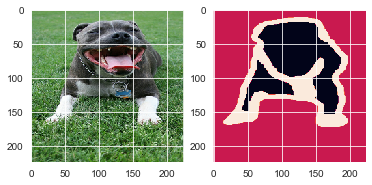

In [157]:
# 展示一张图片和它对应的mask标签
for img, mask in train_dataset.take(1):
    plt.subplot(1, 2, 1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img[0]))
    plt.subplot(1, 2, 2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[0]))

# 2. 获取模型的多个中间层的输出结果

In [62]:
# 首先初始化VGG16预训练网络
conv_base = tf.keras.applications.VGG16(weights='imagenet',
                                        input_shape = (224, 224, 3),
                                        include_top=False)
# conv_base.summary()

定义跳层时需要连接哪些层：
>1. block5_conv3(Conv2D)--->(None, 14, 14, 512);
>2. block4_conv3(Conv2D)--->(None, 28, 28, 512);
>3. block3_conv3(Conv2D)--->(None, 56, 56, 512);

从FCN网络架构中可以看出，从前面卷积开始到最后MaxPooling2D输出是特征提取阶段。最后的MaxPooling2D输出开始就开始进行反卷积了，因此需要获取最后的MaxPooling2D输出。获取之后再开始进行反卷积操作，反卷积操作中会和上面我们自己确定好的前面的层进行跳层连接操作，也就是相加操作。过程也就是：
>block5_pool(MaxPooling2D)进行上采样, 得到的输出形状为(14, 14, 512), 然后与block5_conv3(Conv2D)进行跳层连接相加(tf.add()), 相加之后得到的结果再进行上采样，得到的输出形状为(28, 28, 512), 然后与block4_conv3(Conv2D)进行跳层连接相加, 得到的输出再进行上采样得到输出为(56, 56, 256), 然后与block3_conv3(Conv2D)进行跳层连接相加, 得到的输出再进行两次上采样便得到了与原有图像大小相同的输出。

In [70]:
# 示例：如何获取conv_base的单个中间层输出
# conv_base.layers可以获得所有层的列表，还可以使用下面更好用的方法:
# 获取我们定好的需要进行跳层连接的几个层的输出
block5_conv3_output = conv_base.get_layer('block5_conv3').output

# 这里开始去获取用于跳层连接的中间层的输出
# 如果要获取最后一层的输出，那么可以直接调用模型进行预测便得到了最后层的输出
# 那么对于中间层的输出就需要使用中间层来创建新的子model，然后再调用这个新的子model就可以得到中间层的输出了
# 需要注意的是sub_model会继承conv_base的训练权重
sub_model = tf.keras.models.Model(inputs=conv_base.input, outputs=block5_conv3_output)

In [72]:
# 对于我们现在的实际模型，是需要多个中间层输出的，因此可以使用多输出模型获取多个中间层输出结果
# 先定义每个中间层自己的输出以及conv_base原本最后的输出
# block5_conv3_output = conv_base.get_layer('block5_conv3').output
# block4_conv3_output = conv_base.get_layer('block4_conv3').output
# block3_conv3_output = conv_base.get_layer('block3_conv3').output
# block5_pool_output = conv_base.get_layer('block5_pool').output
# 下面的方式就可以得到一个获取中间层和最后一层的多输出子模型
middle_layer_names = ['block5_conv3', 'block4_conv3', 'block3_conv3', 'block5_pool']
middle_layer_outputs = [conv_base.get_layer(middle_layer_name).output for middle_layer_name in middle_layer_names]
multi_middle_layer_outputs_model = tf.keras.models.Model(inputs=conv_base.input, 
                                                         outputs=middle_layer_outputs)
# 设定这个预训练的子模型不可训练
multi_middle_layer_outputs_model.trainable = False

# 3. 搭建基于预训练模型的语义分割FCN-v1模型

In [100]:
# 使用函数式API搭建自己的模型
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
# 根据输入获取多输出子模型的四个输出结果
block5_conv3_out, block4_conv3_out, block3_conv3_out, block5_pool_out = multi_middle_layer_outputs_model(inputs)
# 将输出结果block5_pool_out进行上采样
# 需要注意的是block5_pool的上采样得到的结果要与block5_conv3_out进行跳层相加的话，要与block5_conv3_out的channle相同，也就是512个
# 因此block5_pool进行上采样时需要在Conv2DTranspose()中设定filter的值为512个
# 另外一点的是要让block5_pool进行上采样后得到的输出的形状为(14, 14)，也就是自己原本尺寸的两倍的话，需要选择strides为2, 并且填充方式为'same'填充
block5_pool_upsampling_out = tf.keras.layers.Conv2DTranspose(filters=512, 
                                                             kernel_size=(3, 3), 
                                                             strides=(2, 2),
                                                             padding='same',
                                                             activation='relu')(block5_pool_out)
# 为了让模型最后表现的更好，这里老师建议对上采样后的结果进行卷积提取特征
block5_pool_upsampling_out = tf.keras.layers.Conv2D(filters=512,
                                                    kernel_size=(3, 3),
                                                    padding='same',
                                                    activation='relu')(block5_pool_upsampling_out)
# 完成上采样后要去前面的层进行调成连接相加
skip_add_out1 = tf.add(block5_pool_upsampling_out, block5_conv3_out)
# 对skip_add_out1进行上采样
skip_add_out1_upsampling = tf.keras.layers.Conv2DTranspose(filters=512, 
                                                           kernel_size=(3, 3), 
                                                           strides=(2, 2),
                                                           padding='same',
                                                           activation='relu')(skip_add_out1)
# 对skip_add_out1_upsampling添加卷积进行特征提取
skip_add_out1_upsampling = tf.keras.layers.Conv2D(filters=512,
                                                  kernel_size=(3, 3),
                                                  padding='same',
                                                  activation='relu')(skip_add_out1_upsampling)
# 将skip_add_out1_upsampling和block4_conv3进行跳层连接相加
skip_add_out2 = tf.add(skip_add_out1_upsampling, block4_conv3_out)
# 对skip_add_out2进行上采样
skip_add_out2_upsampling = tf.keras.layers.Conv2DTranspose(filters=256, 
                                                           kernel_size=(3, 3), 
                                                           strides=(2, 2),
                                                           padding='same',
                                                           activation='relu')(skip_add_out2)
# 对skip_add_out2_upsampling添加卷积进行特征提取
skip_add_out2_upsampling = tf.keras.layers.Conv2D(filters=256,
                                                  kernel_size=(3, 3),
                                                  padding='same',
                                                  activation='relu')(skip_add_out2_upsampling)
# 将skip_add_out2_upsampling和block3_conv3进行跳层连接相加
skip_add_out3 = tf.add(skip_add_out2_upsampling, block3_conv3_out)


# 对skip_add_out3进行上采样以便恢复到原图大小尺寸
skip_add_out3_upsampling_1 = tf.keras.layers.Conv2DTranspose(filters=128, 
                                                             kernel_size=(3, 3), 
                                                             strides=(2, 2),
                                                             padding='same',
                                                             activation='relu')(skip_add_out3)
# 对skip_add_out3_upsampling添加卷积进行特征提取
skip_add_out3_upsampling_1 = tf.keras.layers.Conv2D(filters=128,
                                                    kernel_size=(3, 3),
                                                    padding='same',
                                                    activation='relu')(skip_add_out3_upsampling_1)
# 对skip_add_out3_upsampling_1进行再次反卷积以便恢复到原图尺寸
prediction = tf.keras.layers.Conv2DTranspose(filters=3, 
                                             kernel_size=(3, 3), 
                                             strides=(2, 2),
                                             padding='same',
                                             activation='softmax')(skip_add_out3_upsampling_1)
# shape=(None, 224, 224, 3)
prediction.shape 

TensorShape([None, 224, 224, 3])

In [110]:
model = tf.keras.models.Model(inputs=inputs, outputs=prediction)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
history = model.fit(train_dataset, epochs=8, steps_per_epoch=train_count//BATCH_SIZE,

                    validation_data=test_dataset, validation_steps=test_count//BATCH_SIZE)

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
EPOCHS = 15
epochs = range(EPOCHS)
plt.figure()
plt.plot(epochs, train_loss, 'r', label='Training_loss')
plt.plot(epochs, val_loss, 'b', label='Validation_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.legend()
plt.show()

In [ ]:
for image, mask in test_dataset.take(1):
    pred_mask = model.predict(image)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    # 这里...代表取前面所有维度，tf.newaxis代表对最后的维度扩展1，使得pred_mask的维度变成(224, 224, 1)
    pred_mask = pred_mask[..., tf.newaxis]
    
    plt.figure(figsize=(10, 10))
    num = 3
    # 画出三种图片及其对应的真实mask和预测mask
    for i in range(num):
        plt.subplot(num, 3, i*num+1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image[i]))
        plt.subplot(num, 3, i*num+2)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[i]))
        plt.subplot(num, 3, i*num+3)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_mask[i]))

In [ ]:
tf.keras.optimizers.Adam(learning_rate=0.0005)

In [ ]:
for image, mask in train_dataset.take(1):
    pred_mask = model.predict(image)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    # 这里...代表取前面所有维度，tf.newaxis代表对最后的维度扩展1，使得pred_mask的维度变成(224, 224, 1)
    pred_mask = pred_mask[..., tf.newaxis]
    
    plt.figure(figsize=(10, 10))
    num = 3
    # 画出三种图片及其对应的真实mask和预测mask
    for i in range(num):
        plt.subplot(num, 3, i*num+1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image[i]))
        plt.subplot(num, 3, i*num+2)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[i]))
        plt.subplot(num, 3, i*num+3)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_mask[i]))